In [1]:
# limit the thread used by numpy for better parallelization
import os

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from Triangle.Constants import *
from Triangle.FFTTools import *
from Triangle.Noise import *
from Triangle.Orbit import *
from Triangle.Data import *
from Triangle.Interferometer import *
from Triangle.TDI import *
from Triangle.Glitch import *
from Triangle.GW import *
from Triangle.Cosmology import LuminosityDistance, z_dl

import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'

import multiprocessing
if __name__ == "__main__":
    multiprocessing.set_start_method("fork")
# print("number of cpus =", multiprocessing.cpu_count())
# pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


## Load data 

In [3]:
h5filename = "/media/ps/One Touch/TDCII_Data/2_SingleSource_Dataset/data/MBHB_PhenomT_TDIXYZ.h5"
with h5py.File(h5filename, "r") as h5file:
    data_dict = read_dict_from_h5(h5file["/"])
data_dict.keys()

dict_keys(['XYZ', 'time'])

In [4]:
h5filename = "/media/ps/One Touch/TDCII_Data/2_SingleSource_Dataset/data/MBHB_PhenomT_parameters.h5"
with h5py.File(h5filename, "r") as h5file:
    param_dict = read_dict_from_h5(h5file["/"])
param_dict.keys()

dict_keys(['chirp_mass', 'coalescence_phase', 'coalescence_time', 'inclination', 'latitude', 'longitude', 'luminosity_distance', 'mass_ratio', 'psi', 'spin_1z', 'spin_2z'])

In [5]:
param_dict["coalescence_time"]

array([330.58527006,  73.49530626, 168.86414951,  14.52710675,
       263.12286916, 262.20426673, 218.27529303, 150.01865017,
       182.99311027,  82.98448095, 167.29296122, 180.01226846,
       273.56257371,  98.10365109, 328.17478035, 107.611646  ,
        35.84100334, 312.72149569, 353.72683702, 151.73862225,
       292.72462148,  94.09561112, 241.3897833 , 111.91042885,
       274.51400134, 239.17347726, 324.8454229 ,  22.98448537,
        88.54396279, 214.63716367, 142.89093574, 133.94643428,
       334.41206412, 235.34272096, 330.55065225,  66.81444399,
       258.27556376, 346.84910377, 161.91418656, 298.96960319,
       294.09184798, 350.35219838,  49.85508333, 341.41560924,
       196.50223474, 322.51966869, 341.26243426, 312.22752188,
       181.16372312, 269.2805559 ])

## Search settings 

In [6]:
t_start = 13.8 * DAY 
Tobs = 1 * DAY 
t_end = t_start + Tobs 

time_idx = np.where((data_dict["time"] >= t_start)&(data_dict["time"] <= t_end))[0]
data_time = data_dict["time"][time_idx]
dt = data_time[1] - data_time[0]
channel_names = list(data_dict["XYZ"].keys())
data_channels_td = np.array([data_dict["XYZ"][ch][time_idx] for ch in channel_names])
print(data_time.shape, data_channels_td.shape)

data_channels_fd = []
FT_args = dict(fsample=1./dt, window_type="tukey", window_args_dict=dict(alpha=0.05))
for i in range(3):
    ff, xf = FFT_window(data_channels_td[i], **FT_args)
    data_channels_fd.append(xf)
data_frequency = ff.copy()
data_channels_fd = np.array(data_channels_fd)

mask = np.ones_like(data_frequency, dtype=bool)
for i in range(1, 41):
    mask_idx = np.where(np.abs(data_frequency - i*0.025)<i*3e-4)[0]
    mask[mask_idx] = False 
data_frequency = data_frequency[mask]
data_channels_fd = data_channels_fd[:, mask]
print(data_frequency.shape, data_channels_fd.shape)

a_tmp, e_tmp, t_tmp = AETfromXYZ(X=data_channels_fd[0], Y=data_channels_fd[1], Z=data_channels_fd[2])
data_channels_opt_fd = np.array([a_tmp, e_tmp, t_tmp])
channel_names_opt = ["A2", "E2", "T2"]

orbit = Orbit(OrbitDir="../OrbitData/MicroSateOrbitEclipticTCB")
PSDfunc = TDIPSDs()
arms = dict()
for key in MOSA_labels: 
    arms[key] = orbit.LTTfunctions()[key]((t_end+t_start)/2.)
arms = MOSADict(arms)
data_psd_opt = np.array([
    PSDfunc.PSD_A2_unequal(data_frequency, arms), 
    PSDfunc.PSD_E2_unequal(data_frequency, arms), 
    PSDfunc.PSD_T2_unequal(data_frequency, arms), 
])

(17281,) (3, 17281)
(8224,) (3, 8224)


## Signal generator 

In [7]:
source_idx = np.where((param_dict["coalescence_time"]>t_start/DAY)&(param_dict["coalescence_time"]<=t_end/DAY))[0]
mbhb_parameters = dict() 
for k, v in param_dict.items(): 
    mbhb_parameters[k] = v[source_idx]
mbhb_parameters

{'chirp_mass': array([1655772.19023232]),
 'coalescence_phase': array([3.50665676]),
 'coalescence_time': array([14.52710675]),
 'inclination': array([2.76989698]),
 'latitude': array([-0.79356905]),
 'longitude': array([3.53967404]),
 'luminosity_distance': array([49781.47256516]),
 'mass_ratio': array([0.29485361]),
 'psi': array([0.70651242]),
 'spin_1z': array([0.770113]),
 'spin_2z': array([0.248721])}

In [8]:
approx = "IMRPhenomT"

mbhb_waveform_generator = MBHB_Injection(approx_method=approx, buffer=True)
mbhb_response_generator = FastMichelsonTDIResponse(
    orbit=orbit, 
    tcb_times=data_time.copy(), 
    use_gpu=False, 
    drop_points=int(1000./dt), 
    interp_method="Spline3",  # use a safe interp order to ensure accuracy 
)

In [9]:
aa, bb = mbhb_waveform_generator(params=mbhb_parameters, times=data_time)
aa.shape, bb.shape 

((4491,), (4491,))

In [10]:
mbhb_response_generator(parameters=mbhb_parameters, waveform_generator=mbhb_waveform_generator, optimal_combination=True)

KeyboardInterrupt: 

In [ ]:
def signal_generator_fd(params): 
    res_x, res_y, res_z = mbhb_response_generator(parameters=params, waveform_generator=mbhb_waveform_generator, optimal_combination=True)
    res_a, res_e, res_t = AETfromXYZ(res_x, res_y, res_z)
    _, res_af = FFT_window(res_a, **FT_args)
    _, res_ef = FFT_window(res_e, **FT_args)
    _, res_tf = FFT_window(res_t, **FT_args)
    res_aetf = np.array([res_af, res_ef, res_tf])
    return res_aetf[:, mask]

In [ ]:
model_channels_fd = signal_generator_fd(mbhb_parameters)
model_channels_fd.shape 

KeyboardInterrupt: 

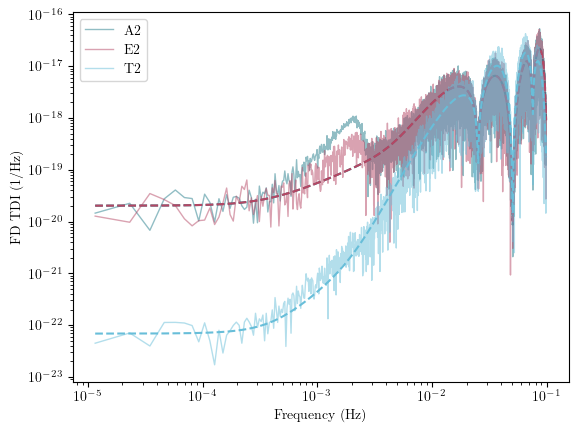

In [ ]:
color_dict = dict(A2=GREEN1, E2=RED, T2=BLUE)
for ich, nch in enumerate(channel_names_opt):
    plt.loglog(data_frequency, np.abs(data_channels_opt_fd[ich]), label=nch, linewidth=1, color=color_dict[nch], alpha=0.5)
    plt.loglog(data_frequency, np.sqrt(data_psd_opt[ich] * Tobs / 2.), linestyle="--", color=color_dict[nch])
plt.xlabel("Frequency (Hz)")
plt.ylabel("FD TDI (1/Hz)")
plt.legend(loc="upper left")

## Likelihood 

In [ ]:
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())

Process ForkPoolWorker-21:
Process ForkPoolWorker-26:
Process ForkPoolWorker-29:
Process ForkPoolWorker-22:
Process ForkPoolWorker-25:
Process ForkPoolWorker-30:
Process ForkPoolWorker-24:
Process ForkPoolWorker-31:
Process ForkPoolWorker-4:
Process ForkPoolWorker-28:
Process ForkPoolWorker-11:
Process ForkPoolWorker-27:
Process ForkPoolWorker-7:
Process ForkPoolWorker-32:
Process ForkPoolWorker-17:
Process ForkPoolWorker-23:
Process ForkPoolWorker-5:
Process ForkPoolWorker-16:
Process ForkPoolWorker-3:
Process ForkPoolWorker-15:
Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Process ForkPoolWorker-6:
Process ForkPoolWorker-8:
Process ForkPoolWorker-18:
Process ForkPoolWorker-13:
Process ForkPoolWorker-12:
Process ForkPoolWorker-10:
Process ForkPoolWorker-14:
Process ForkPoolWorker-9:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent c